# Ground-roll attenuation model with attention

Raw field seismograms contain noises of various nature. One type of noise is assosiated with ground-roll waves propagation. The model should suppress the ground-roll noise and keep desired signal unchanged.

* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Runnig time](#Running-time)
* [Model evaluation](#Model-evaluation)
* [Criticism](#Criticism)
* [Conclusion](#Conclusion)
* [Suggestions for improvements](#Suggestions-for-improvements)

## Dataset

We exploit the Dataset 1 from a list of dataset on ground-roll attenuation. Description of the Dataset 1 is available [here](https://github.com/analysiscenter/SeismicPro/blob/master/datasets/noise_attenuation.ipynb). 10 first seismograms of the train part we keep for model training, the rest ones for testing. 

Required imports:

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

sys.path.append('../../..')

from seismicpro.batchflow import Pipeline, V, B, L, I, W
from seismicpro.batchflow.models.tf.layers import conv_block
from seismicpro.batchflow.models.tf import UNet

from seismicpro.src import (SeismicDataset, FieldIndex, TraceIndex, statistics_plot,
                            seismic_plot, spectrum_plot, merge_segy_files)
from seismicpro.models import UnetAtt, attention_loss, FieldMetrics

%env CUDA_VISIBLE_DEVICES=5

env: CUDA_VISIBLE_DEVICES=5


Index dataset

In [2]:
path_raw = '/notebooks/data/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/data/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))
index.head()

,offset,TraceNumber,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,lift,lift
FieldRecord,,,,,,
111906,35,1656,1,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,1,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,36,1657,2,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,2,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,78,1655,3,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,3,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,79,1658,4,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,4,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...
111906,127,1654,5,/notebooks/data/noise_dataset_1/DN02A_LIFT_AMP...,5,/notebooks/data/noise_dataset_1/DN02B_SHOTS_LI...


Reserve 10 field records for model training:

In [3]:
tindex = TraceIndex(index.create_subset(index.indices[:10]))
train_set = SeismicDataset(tindex)

## Model architecture

Model consists of 2 U-Net branches, the first one is for signal filtering, the second one is for attention mask.

Define the model config and loss function:

In [4]:
model_config = {
    'initial_block/inputs': 'trace_raw', #'offset'],
    'inputs': dict(trace_raw={'shape': (3000, 1)},
#                    offset={'shape': (1, )},
                   lift={'name': 'targets', 'shape': (3000, 1)}),

    'loss': (attention_loss, {'balance': 0.05}),
    'optimizer': ('Adam', {'learning_rate': 0.001}),
    'common/data_format': 'channels_last',
    'body': {'main': {
                    'encoder/num_stages': 5,
                    'encoder/blocks': dict(layout='caca', filters=[16, 32, 64, 128, 256], kernel_size=7, activation=tf.nn.elu),
                    'encoder/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),

                    'decoder/num_stages': 5,
                    'decoder/blocks': dict(layout='caca', filters=[16, 32, 64, 128, 256][::-1], kernel_size=7, activation=tf.nn.elu),
                    'decoder/upsample': dict(layout='tad', kernel_size=7, strides=2,
                                     dropout_rate=0.05, activation=tf.nn.elu,),
                    },
             'attn': {
                    'encoder/num_stages': 4,
                    'encoder/blocks': dict(layout='caca', filters=[8, 16, 32, 64], kernel_size=3, activation=tf.nn.elu),
                    'encoder/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),

                    'decoder/num_stages': 4,
                    'decoder/blocks': dict(layout='caca', filters=[8, 16, 32, 64][::-1], kernel_size=3, activation=tf.nn.elu),
                    'decoder/upsample': dict(layout='tad', kernel_size=3, strides=2,
                                     dropout_rate=0.05, activation=tf.nn.elu),
                    },
                   },
}

## Training

Training pipeline actions:
* loading a batch of raw and target traces
* model weights update

Optimizer configuration:
* optimizer: Adam
* learning_rate = 0.0001

Loss balance: 0.05

Training scheme:
* ```batch_size``` = 64
* ```n_epochs``` = 2.

Define a train pipeline:

In [5]:
def exp_stack(x):
    return np.expand_dims(np.vstack(x), -1)

def make_data(batch, **kwagrs):
    return {'trace_raw': exp_stack(batch.raw),
#                           'offset': np.vstack(batch.trace_headers('offset')),
                          'lift': exp_stack(batch.lift)}

train_pipeline = (Pipeline()
                  .init_model('static', UnetAtt, name='unet', config=model_config)
                  .init_variable('loss', default=list())
                  .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                  .train_model('unet', make_data=make_data, fetches='loss', save_to=V('loss', 'a'))
                 )

Specify a dataset for model training:

In [6]:
train_pipeline = train_pipeline << train_set

Run model training for 3 epochs with batch size of 64:

In [7]:
batch_size = 64

train_pipeline = train_pipeline.run(batch_size=batch_size, n_epochs=3, drop_last=True,
                                    shuffle=True, bar=True, bar_desc=W(V('loss')[-1].format('Current loss is: {:7.7}')) )

Current loss is: 0.06387243: 100%|██████████| 1620/1620 [08:31<00:00,  3.24it/s]


Plot loss function decay:

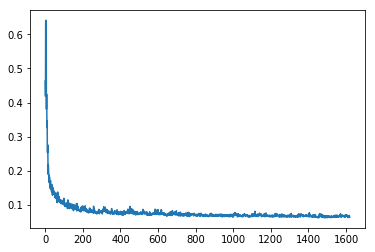

In [8]:
loss = np.array(train_pipeline.get_variable('loss'))
plt.plot(loss)
plt.show()

In [ ]:
model_path = './unet_att_model'
train_pipeline.save_model_now('unet', model_path)

## Inference

For inference we need a ```TraceIndex```, we also keep all SEGY headers from original traces:

In [ ]:
inference_index = TraceIndex(name='raw', extra_headers='all', path=path_raw)

Inference pipeline. Note that one should specify temporary folder where processed batches will be stored before final merge.

In [ ]:
tmp_dump_path = '/data/NA/tmp'

def make_data_inference(batch, **kwagrs):
    return {"feed_dict": {'trace_raw': exp_stack(batch.raw),
                          'offset': np.vstack(batch.trace_headers('offset'))}}

inference_ppl = (Pipeline()
                 .import_model('unet', train_pipeline)
#                  .load_model("static", UnetAtt, 'unet', path=model_path)    # Use this action instead of `import_model` if you didn't run training
                 .init_variable('res')
                 .load(components='raw', fmt='segy', tslice=np.arange(3000))
                 .predict_model('unet', make_data=make_data_inference,
                                fetches=['out_lift'], save_to=B('raw'))
                 .dump(path=L(lambda x: os.path.join(tmp_dump_path, str(x) + '.sgy'))(I()),
                       src='raw', fmt='segy', split=False)
                 )

Specify a dataset for inference pipeline:

In [ ]:
inference_set = SeismicDataset(inference_index)

inference_ppl = inference_ppl << inference_set

Run inference pipeline with appropriate ```batch_size```:

In [ ]:
batch_size = 2500
inference_ppl.run(batch_size, n_epochs=1, drop_last=False, shuffle=False, bar=True)

Final and rather optional step is to merge dumped files into a single file:

In [ ]:
output_path = '/data/NA/processed/merged.sgy'
merge_segy_files(output_path=output_path, extra_headers='all',
                 path=os.path.join(tmp_dump_path, '*.sgy'))

For a quick estimation let's look at the first field record from the final file:

In [ ]:
output_index = FieldIndex(name='unet_lift', extra_headers=['offset'], path=output_path)

(SeismicDataset(output_index).next_batch(1)
 .load(components='unet_lift', fmt='segy', tslice=np.arange(3000))
 .sort_traces(src='unet_lift', dst='unet_lift', sort_by='offset')
 .seismic_plot('unet_lift', index.indices[0], figsize=(10, 7), vmax=0.1, vmin=-0.1, cmap='gray'))

## Running time

For GTX 1080 we obtain:
* training time per one batch of size 64 traces is 0.3 sec
* full model training time with batch size 64 is 8:50 min
* inference time per one batch of size 2500 traces is 3.78 sec

## Model evaluation

For model evaluation we 1) consider attention mask produced by model and compare it with thresholded absolute difference of target and input traces; 2) inspect attention mask parameters (sigmoid center and smoothness); 3) compare signal power spectrum in ground-roll area between target seismogram and model output.

Test pipeline:

In [9]:
fetches=['out_lift', 'attention_sigmoid', 'sigmoid_center']

test_pipeline = (Pipeline()
                 .import_model('unet', train_pipeline)
                 .init_variable('res', init_on_each_run=list())
                 .init_variable('raw', init_on_each_run=list())
                 .init_variable('lift', init_on_each_run=list())
                 .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                 .update_variable('raw', B('raw'), mode='a')
                 .update_variable('lift', B('lift'), mode='a')
                 .predict_model('unet', make_data=make_data, fetches=fetches, save_to=V('res', 'a')))

Select a sample seismogram for testing:

In [10]:
i = 20
test_set = SeismicDataset(TraceIndex(index.create_subset(index.indices[i: i+1])))

Run test pipeline:

In [11]:
test_pipeline = test_pipeline << test_set
test_pipeline = test_pipeline.run(batch_size=1000, n_epochs=1, drop_last=False,
                                  shuffle=False, bar=True)

100%|██████████| 4/4 [00:08<00:00,  2.46s/it]


Arrange results:

In [12]:
raw = np.vstack([np.vstack(x) for x in test_pipeline.get_variable('raw')])
lift = np.vstack([np.vstack(x) for x in test_pipeline.get_variable('lift')])
out = np.squeeze(np.vstack([x[0] for x in test_pipeline.get_variable('res')]))
att = np.squeeze(np.vstack([x[1] for x in test_pipeline.get_variable('res')]))
sigm_center = np.vstack([x[2] for x in test_pipeline.get_variable('res')])

### Visual estimation

Show raw seismogram, model attention mask, model output and difference between model output and raw input:

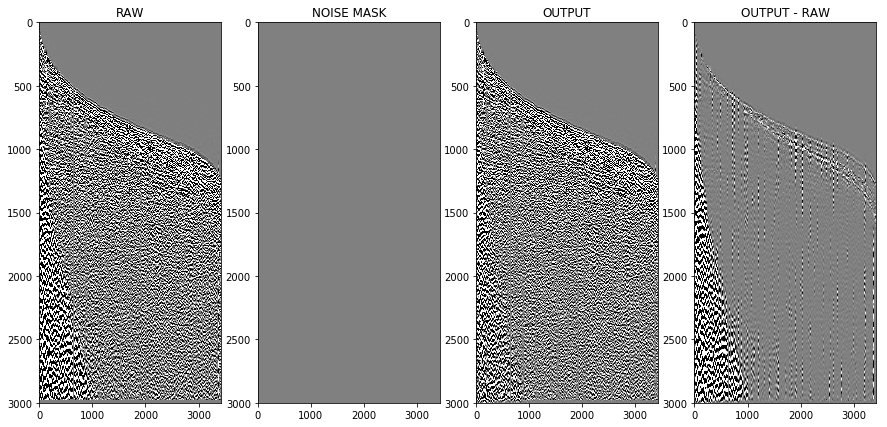

In [13]:
cv = 0.1
seismic_plot([raw, att, out, out - raw],
             figsize=(15, 7), names=['RAW', 'NOISE MASK', 'OUTPUT', 'OUTPUT - RAW'],
             cmap='gray', vmin=-cv, vmax=cv)

Show model output, traget seismogram difference between them:

In [ ]:
seismic_plot([out, lift, out - lift],
             figsize=(15, 7), names=['OUTPUT', 'LIFT', 'DIFF'],
             cmap='gray', vmin=-cv, vmax=cv)

Note a difference outside the ground-roll area.

### MAE metrics

Estimate MAE between model output and target seismogram:

In [ ]:
mtr = FieldMetrics(lift, out)
print('MAE:', mtr.mae())

### Trace correlations

Get correlation coeffitiens between target traces and model output:

In [ ]:
corr = mtr.corr_coef(reduce=None)
plt.plot(corr)
plt.show()

Note that zero correlation occurs due to zero traces in the dataset.

Average correlation is:

In [ ]:
print('Averaged correlation:', mtr.corr_coef())

### IOU for attention mask

Plot sigmoid center locations. We observe a non-trivial dependence of sigmoid parameters on traces and offsets: 

In [ ]:
plt.plot(sigm_center[:, 0])
plt.title('Sigmoid center')
plt.show()

Comparison of attention mask and thresholded absolute difference between raw inputs and target traces:

In [ ]:
seismic_plot([att > 0.5, abs(lift - raw) < .05],
             names=['NOISE MASK', 'LIFT - INPUT'],
             figsize=(15, 6), vmin=0, vmax=1, cmap='gray')

Compute IOU for various threshold values:

In [ ]:
thrs = np.arange(0, .5, 0.01)
vals = np.array([FieldMetrics(abs(lift - raw) > p, att < 0.5).iou() for p in thrs])

Plot of IOU metrics aganist various threshold values. We find that threshold at 0.05 gives maximum of IOU:

In [ ]:
plt.plot(thrs, vals)
plt.xlabel('Threshold'), plt.ylabel('IOU')
print('Best threshold is', thrs[np.argmax(vals)], 'with IOU = ', vals.max())
plt.show()

### Power spectrum comparison

Power spectrum comparison in the gourd roll area:

In [ ]:
spectrum_plot([out, lift], frame=(slice(50, 150), slice(1500, 2500)), rate=0.002, max_freq=70,
              figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray', names=['MODEL OUTPUT', ' TARGET LIFT'])

We observe a very similar distribution of power spectrum in the gound-roll area. We do not show plots outside the gound-roll area since the signal is unchanged there due to attention mask.

### Trace statistics comparison

Comparison of rms amplitudes:

In [ ]:
statistics_plot((out, lift), stats='rms_ampl', names=['MODEL OUTPUT', 'LIFT'], figsize=(15, 10),
                vmin=-cv, vmax=cv, cmap='gray')

Comparison of rms frequencies:

In [ ]:
statistics_plot((out, lift), stats='rms_freq', rate=0.002,
                names=['MODEL OUTPUT', 'LIFT'], figsize=(15, 10),
                vmin=-cv, vmax=cv, cmap='gray')

We obsereve that while rms amplitudes are pretty the same, rms frequencies are somewhat differ for small offsets.

### Metrics evaluation on the whole dataset

We will evaluate MAE and averaged trace correlation for each seismogram. The result will be plotted in a scatter plot, where color indicates metrics value and point coordinates correspond to source coordinates.

Index traget and predicted seismograms:

In [ ]:
path_ml = '/data/NA/processed/merged.sgy'
path_lift = '/data/NA/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

m_index = (FieldIndex(name='ml', extra_headers=['SourceX', 'SourceY'], path=path_ml)
           .merge(FieldIndex(name='lift', path=path_lift)))

Define a dataset:

In [ ]:
dset = SeismicDataset(m_index)

Define functions that extract source position and evaluate metrics and a pipeline that we will run on each seismogram:

In [ ]:
def get_pos(batch, *args):
    sx = batch.trace_headers('SourceX', flatten=True)[0]
    sy = batch.trace_headers('SourceY', flatten=True)[0]
    return sx, sy

def eval_mt(batch, *args):
    mt = FieldMetrics(batch.lift[0], batch.ml[0])
    return mt.mae(), mt.corr_coef()
    

metr_pipeline = (Pipeline()
                 .init_variable('mt', init_on_each_run=list())
                 .init_variable('pos', init_on_each_run=list())
                 .load(components=('ml', 'lift'), fmt='segy', tslice=np.arange(3000))
                 .call(get_pos, save_to=V('pos', mode='a'))
                 .call(eval_mt, save_to=V('mt', mode='a')))

Run the pipeline:

In [ ]:
metr_pipeline = metr_pipeline << dset
metr_pipeline = metr_pipeline.run(batch_size=1, n_epochs=1, drop_last=False,
                                  shuffle=False, bar=True)

Arrange results:

In [ ]:
pos = np.vstack(metr_pipeline.get_variable('pos'))
mt = np.vstack(metr_pipeline.get_variable('mt'))

Plot MAE distribution over seismorams:

In [ ]:
plt.scatter(*pos.T, c=mt[:, 0])
plt.colorbar()
plt.title('MAE')
plt.xlabel('SourceX')
plt.ylabel('SourceY')
plt.show()

Plot distribution of the averaged trace correlation over seismorams:

In [ ]:
plt.scatter(*pos.T, c=mt[:, 1])
plt.colorbar()
plt.title('Averaged trace correlation')
plt.xlabel('SourceX')
plt.ylabel('SourceY')
plt.show()

We observe that both metrics are distributed smoothly over seismorgams except for a single oulier (top-left point).

## Criticism

The model is not stable to intializations. Alternative initializations may produce sigmoid parameters depending on trace offset only or zero-constant values. However, it is more or less stable that 1 of 5 initializations results in reasonable sigmoid parameters.

## Conclusion

The Unet Attention model is possible tp provide reasonable noise attentiation in the ground-roll area and leaves signal untouched outside the ground-roll area due to in-situ estimated attention mask. However, traning of the model is sensitive to model initializations and requires accurate balansing of the loss terms. 

## Suggestions for improvements

Adding more constraints on sigmoid parameters to the loss function or clipping values inside the model should help to overcome the model instability. 